**Homework 10**

We'll start with a few imports and our running library of functions.

In [109]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def TrainTestSplit(X,y,p,seed=1):
  '''Splits feature matrix X and target array y into train and test sets
  p is the fraction going to train'''
  np.random.seed(seed) #controls randomness
  size=len(y)
  train_size=int(p*size)
  train_mask=np.zeros(size,dtype=bool)
  train_indices=np.random.choice(size, train_size, replace=False)
  train_mask[train_indices]=True
  test_mask=~train_mask
  X_train=X[train_mask]
  X_test=X[test_mask]
  y_train=y[train_mask]
  y_test=y[test_mask]
  return X_train,X_test,y_train,y_test

def PolyFeatures(x,d):
  X=np.zeros((len(x),d+1))
  for i in range(d+1):
    X[:,i]=x**i
  return X

def AddOnes(X):
  return np.concatenate((X,np.ones((len(X),1))),axis=1)

class Scaler:
  def __init__(self,z):
    self.min=np.min(z,axis=0)
    self.max=np.max(z,axis=0)

  def scale(self,x):
    return (x-self.min)/(self.max-self.min)

  def unscale(self,x):
    return x*(self.max-self.min)+self.min

def train(X,y,max_iter,lr):
  '''MSE minimization by Gradient Descent'''
  X=np.array(X) #Just in case X is a DataFrame
  y=np.array(y) #Just in case y is a Series
  n=len(X)
  coeff=np.ones(X.shape[1]) #Initialize all coeff to be 1 (something to play with?)
  for i in range(max_iter):
    resid=X@coeff-y
    gradient=((X.T)@resid)/n #Lot's of lin alg here. Try to unpack it!
    coeff=coeff-lr*gradient #Gradient Descent step.
  return coeff

def SGD(X,y,epochs,batch_size,lr,alpha=0,beta=0):
  '''Stochastic Gradient Descent With L1 and L2 regularization'''
  #alpha=amount of L1 (Lasso) regularization
  #beta=amount of L2 (Ridge) regularization
  X=np.array(X) #Just in case X is a DataFrame
  y=np.array(y) #Just in case y is a Series
  n=len(X)
  coeff=np.ones(X.shape[1]) #Initialize all coeff to be 1 (something to play with?)
  indices=np.arange(len(X))
  for i in range(epochs):
    np.random.seed(i)
    np.random.shuffle(indices)
    X_shuffle=X[indices]
    y_shuffle=y[indices]
    num_batches=n//batch_size
    for j in range(num_batches):
      X_batch=X_shuffle[j*batch_size:(j+1)*batch_size]
      y_batch=y_shuffle[j*batch_size:(j+1)*batch_size]
      resid=X_batch@coeff-y_batch
      gradient=lr*((X_batch.T)@resid)/len(X_batch)+alpha*(2*(coeff>0)-1)+beta*coeff
      coeff=coeff-gradient #Gradient Descent step.
    if n%batch_size!=0: #Check if there is a smaller leftover batch
      X_batch=X_shuffle[num_batches*batch_size:] #last batch
      y_batch=y_shuffle[num_batches*batch_size:] #last batch
      resid=X_batch@coeff-y_batch
      gradient=lr*((X_batch.T)@resid)/len(X_batch)+alpha*(2*(coeff>0)-1)+beta*coeff
      coeff=coeff-gradient
  return coeff

def predict(X,coeff): #If X was scaled, then this will return scaled predictions
  return X@coeff

def MSE(pred,y):
  return np.sum((pred-y)**2)/len(y)

Now we'll load the iris dataset as a pandas DataFrame.

In [111]:
iris=(pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv',index_col=0))

In this assignment you'll create a general Logistic Regression funcation, and train it to predict which flowers are virginicas just from their petal length and width. Since this is a very simple dataset, we won't worry about doing a train/test split, scaling, etc.

To begin, we select the `Petal.Length` and `Petal.Width` columns to be our features `X`, and for our target `y` we'll create a boolean array which is True if the species is virginica, and False otherwise.

In [112]:
X=np.array(iris[['Petal.Length','Petal.Width']])
y=np.array(iris['Species']=='virginica')

Now, define a function `sigmoid` by the following formula:
$$\sigma(t)=\frac{1}{1+e^{-t}}$$

Be sure to use np.exp, and not math.exp, so that all operations are vectorized.

In [113]:
def sigmoid(t):
  return 1 / (1 + np.exp(-t))

What we are after is to find values of m, n, and b so that $$\sigma(m*length+n*width+b)$$ is a good predictor of the probability of a flower being a virginica.

In general, for a feature matrix `X` (with a column of ones), we want to find a vector of coefficients `coeff` so that $\sigma$(X@coeff) is a good predictor of the target column.   

Define a function `proba` that gives the value of this probability.

In [114]:
def proba(X,coeff):
  return sigmoid(X @ np.transpose(coeff))

Use a logistic model defined by m=-2, n=0.5, and b=10 to generate an array of probabilities for the matrix X of petal lengths and widths (don't forget to add a column of ones!).

In [115]:
m = -2
n = 0.5
b = 10

coeff = [-2, 0.5, 10]

In [116]:
ones_column = np.ones((X.shape[0], 1), dtype=X.dtype)

In [117]:
X_with_ones = np.append(X, ones_column, axis = 1)
X_with_ones.shape

(150, 3)

In [118]:
probs = proba(X_with_ones, coeff)

Write a function `predict` that takes an array of probabilities and returns True for each one that is above 0.5, and False otherwise. Then, use this function to make predictions on weather or not each flower is a virginica, based on the logistic model with coefficients m=-2, n=0.5, and b=10.

In [119]:
def predict(probs):
  return probs > 0.5

predictions = predict(probs)

Write a function `accuracy` that takes an array or predicted True/False values and an array of target True/False values, and determines the accuracy of the predictions. Then, use this to determine the accuracy of the logistic model with coefficients m=-2, n=0.5, and b=10.

In [120]:
def accuracy(pred,y):
  return np.sum(pred == y) / len(y)

acc = accuracy(predictions, y)

The function we will optimize is not accuracy, but rather the log of the probability that our guesses for the target column are correct, if we guess according to the probabilities given by our model (log-loss). To compute this, define a function that calculates the *mean* log loss. Then, apply this function to the logistic model with coefficients m=-2, n=0.5, and b=10. As discussed in class, the log loss is given by:

$$\log \left(\prod \limits _{target_i=T} p_i \cdot \prod \limits _{target_i=F} (1-p_i)\right)\\
=\sum \limits _{target_i=T} \log(p_i) + \sum \limits _{target_i=F} \log(1-p_i)\\
=\sum \limits _i  target_i \log(p_i) +  (1-target_i)\log(1-p_i)$$

As in the case of RSS vs MSE, the mean log loss is obtained from the log loss by dividing by the number of rows in our dataset, to account for datasets of varying size.

In [131]:
def LogLoss(probs,y):
  return (np.dot(y, np.log(probs)) + np.dot(1 - y, np.log(1 - probs)))

LL = LogLoss(probs, y) / X.shape[0]
LL

-3.450044815807957

The above quantity is a number between $-\infty$ and $0$, with numbers closer to 0 being better. Rather than maximize this, we will minimze its negation (i.e. we'll put a negative sign in front and use gradient descent).

For example, in the case of our iris model, the gradient of the mean log loss is given by the three partial derivatives:
$$\frac{\partial ll}{\partial m}= \frac{1}{len(y)}\sum \limits _i (p_i-target_i)length_i$$
$$\frac{\partial ll}{\partial n}= \frac{1}{len(y)}\sum \limits _i (p_i-target_i)width_i$$
$$\frac{\partial ll}{\partial b}= \frac{1}{len(y)}\sum \limits _i (p_i-target_i)$$

Again, we will also divide these by the number of rows in our dataset, to account for datasets of varying size.

In general, if you have a feature matrix X and a logistic model giving probabilities `proba` for a target `y` then the gradient vector is given by `X.T@(proba-y)/len(X)`.

Use this to modify the SGD function defined in the previous homework assignment to find an optimal Logistic regression model. As before, we will use stochastic (batch) gradient descent, with possible L1 and L2 regularization.

In [141]:
def LogisticSGD(X,y,epochs,batch_size,lr,alpha=0,beta=0):
  '''Stochastic Gradient Descent for Logistic Regression'''
  #alpha=amount of L1 (Lasso) regularization
  #beta=amount of L2 (Ridge) regularization
  X=np.array(X) #Just in case X is a DataFrame
  y=np.array(y) #Just in case y is a Series
  n=len(X)
  coeff=np.ones(X.shape[1]) #Initialize all coeff to be 1 (something to play with?)
  indices=np.arange(len(X))
  for i in range(epochs):
    np.random.seed(i)
    np.random.shuffle(indices)
    X_shuffle=X[indices]
    y_shuffle=y[indices]
    num_batches=n//batch_size
    for j in range(num_batches):
      X_batch=X_shuffle[j*batch_size:(j+1)*batch_size]
      y_batch=y_shuffle[j*batch_size:(j+1)*batch_size]
      resid=proba(X_batch, coeff)-y_batch
      gradient=lr*((X_batch.T)@resid)/len(X_batch)+alpha*(2*(coeff>0)-1)+beta*coeff
      coeff=coeff-gradient #Gradient Descent step.
    if n%batch_size!=0: #Check if there is a smaller leftover batch
      X_batch=X_shuffle[num_batches*batch_size:] #last batch
      y_batch=y_shuffle[num_batches*batch_size:] #last batch
      resid=proba(X_batch, coeff)-y_batch
      gradient=lr*((X_batch.T)@resid)/len(X_batch)+alpha*(2*(coeff>0)-1)+beta*coeff
      coeff=coeff-gradient
  return coeff

Use this function to compute coefficients for a logistic model for the feature matrix X (with a columns of ones added) and target y. Run your code for 2000 epochs, with batch sizes of 50, and learning rate 0.01. For this assignment, we won't worry about regularization, so leave alpha and beta at 0.

In [142]:
epochs = 2000
batch_size = 50
lr = 0.01

In [143]:
newcoeff = LogisticSGD(X_with_ones, y, epochs, batch_size, lr)

Calculate the accuracy of the logistic model you found with these coefficients.

In [144]:
new_probs = proba(X_with_ones, newcoeff)

In [145]:
new_predictions = predict(new_probs)

In [149]:
newaccuracy = accuracy(new_predictions, y)

To see the "decision boundary" between where your model will predict virginica (in blue) vs the other species, run the following code block:

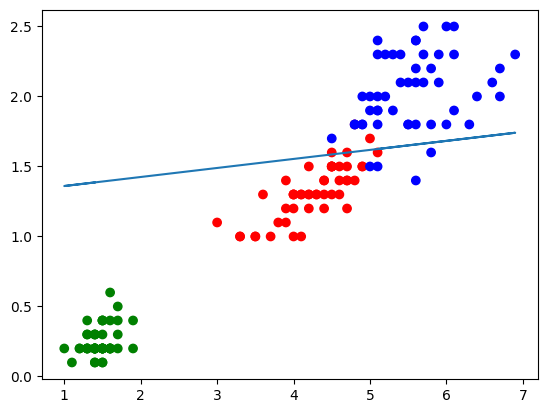

In [150]:
def func(x):
  m=-newcoeff[0]/newcoeff[1]
  b=-newcoeff[2]/newcoeff[1]
  return m*x+b

cdict={'versicolor':'r','setosa':'g','virginica':'b'}
colors=iris.apply(lambda x:cdict[x.Species],axis=1)

plt.scatter(X[:,0],X[:,1],c=colors)
plt.plot(X[:,0],func(X[:,0]))